Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [206]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [207]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [208]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [258]:
folders = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Remove output folders if exists before running Augmentation
for class_folder in folders:
    # Define the output folder path
    output_folder_path = os.path.join(data_dir_train, class_folder, 'output')
    # Check if the output folder exists
    if os.path.exists(output_folder_path):
        # Delete the output folder and all its contents
        import shutil
        shutil.rmtree(output_folder_path)
        print(f"Deleted output folder in {class_folder}")
    else:
        print(f"No output folder found in {class_folder}")

Deleted output folder in actinic keratosis
Deleted output folder in basal cell carcinoma
Deleted output folder in dermatofibroma
Deleted output folder in melanoma
Deleted output folder in nevus
Deleted output folder in pigmented benign keratosis
Deleted output folder in seborrheic keratosis
Deleted output folder in squamous cell carcinoma
Deleted output folder in vascular lesion


### Check an image from the dataset

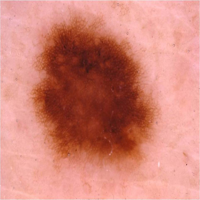

In [210]:
#checking a image from the dataset
nevus_eg = list(data_dir_train.glob('nevus/*'))
im=PIL.Image.open(str(nevus_eg[20]))
image = im.resize((200, 200))
image

### Load using keras.preprocessing and Create a dataset

In [211]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation. Let's load these images off disk using the helpful `tf.keras.preprocessing.image_dataset_from_directory` utility.

In [212]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [213]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [214]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

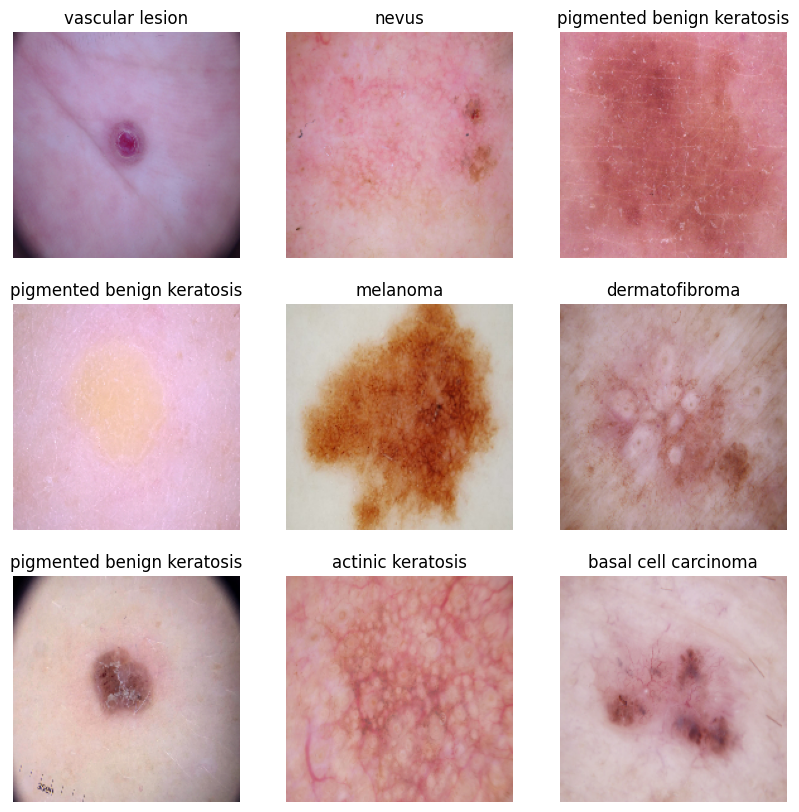

In [215]:
## visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [216]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the first model

In [217]:
## Normalizing the pixels
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

In [218]:
num_classes = len(class_names)

In [219]:
model1 = Sequential([
  keras.Input(shape=(img_height, img_width, 3)),
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model 1

In [220]:
## Using optimiser `adam` and loss function as `SparseCategoricalCrossentropy`
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [221]:
## Summary of all layers
model1.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model 1

In [222]:
%%time
epochs = 20
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.1963 - loss: 2.1650 - val_accuracy: 0.2327 - val_loss: 1.9091
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.2881 - loss: 1.8707 - val_accuracy: 0.3490 - val_loss: 1.7456
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.4421 - loss: 1.5649 - val_accuracy: 0.4922 - val_loss: 1.5089
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5075 - loss: 1.4468 - val_accuracy: 0.5145 - val_loss: 1.3788
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.5481 - loss: 1.2746 - val_accuracy: 0.4966 - val_loss: 1.4279
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5485 - loss: 1.3270 - val_accuracy: 0.5280 - val_loss: 1.3911
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5963 - loss: 1.1364 - val_accuracy: 0.4922 - val_loss: 1.4535
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.6171 - loss: 1.0804 - val_accuracy: 0

### Visualizing training results for model 1

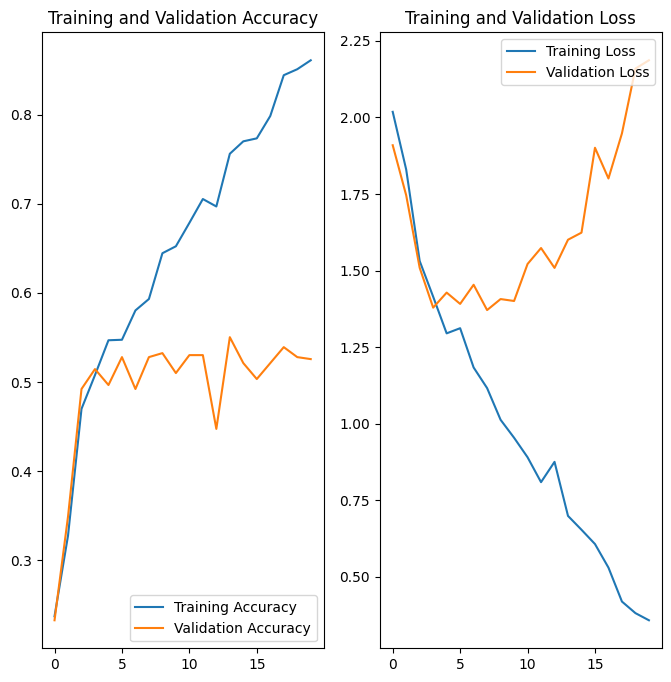

In [223]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of Model 1:

##### The training accuracy is over 86% but the validation accuracy is 52%
##### Similarly, the training loss is 0.3550 while the validation loss is 2.1865
##### The above graph also shows the same trend with Training Loss continuously reduces, but the Validation Loss starts increasing after a few epochs.
##### The Model is clearly overfitting

### Augmentation of the training images

In [224]:
# Augmentation strategy to identify images in different shades, zoom condition, rotated and flipped images
data_augmentation = keras.Sequential(
  [
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal_and_vertical"),  # flip both horizontally and vertically
    layers.RandomRotation(0.2),  # increase rotation range and use nearest neighbor filling
    layers.RandomZoom(0.2),  # increase zoom range and specify width/height factors
    layers.RandomContrast(0.2),  # increase contrast range
    layers.RandomBrightness(0.1),  # add random brightness augmentation
  ]
)

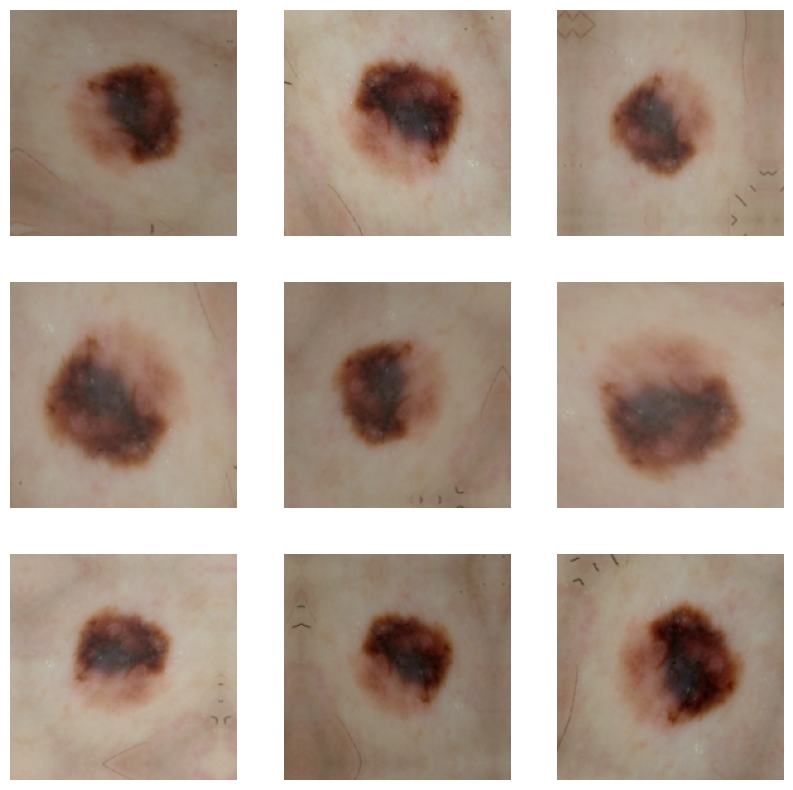

In [225]:
# Display one instance of the augmented image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model 2 - Using Data Augmentation and Dropout layers

In [226]:
## Using dropout layer with drop percentage of 0.2
model2 = Sequential([
  keras.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model 2

In [227]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [228]:
model2.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,193 (7.94 MB)

 Trainable params: 2,081,193 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model 2

In [229]:
%%time
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.1848 - loss: 2.0699 - val_accuracy: 0.3937 - val_loss: 1.7314
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.3594 - loss: 1.7474 - val_accuracy: 0.4340 - val_loss: 1.5720
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.4115 - loss: 1.6531 - val_accuracy: 0.3691 - val_loss: 1.7366
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.4057 - loss: 1.6622 - val_accuracy: 0.4676 - val_loss: 1.5034
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.4240 - loss: 1.5747 - val_accuracy: 0.4072 - val_loss: 1.6273
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.4613 - loss: 1.5179 - val_accuracy: 0.4922 - val_loss: 1.4721
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.4500 - loss: 1.5025 - val_accuracy: 0.4989 - val_loss: 1.4126
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.4773 - loss: 1.4016 - val_accuracy: 

### Visualizing the results of model 2

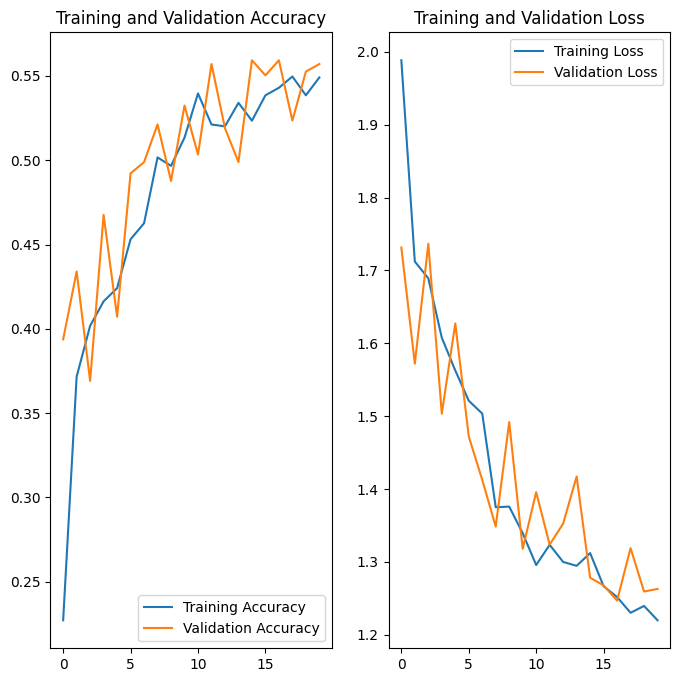

In [230]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of Model 2:

##### The model is not as overfitted as previous one.But we have some over fitting
##### For Training -> accuracy: 0.5669 - loss: 1.1884
##### For Validation -> val_accuracy: 0.5570 - val_loss: 1.2629
##### All are reduced.

##### This model is better than previous one but still low accuracy

#### Plotting the images count under each class

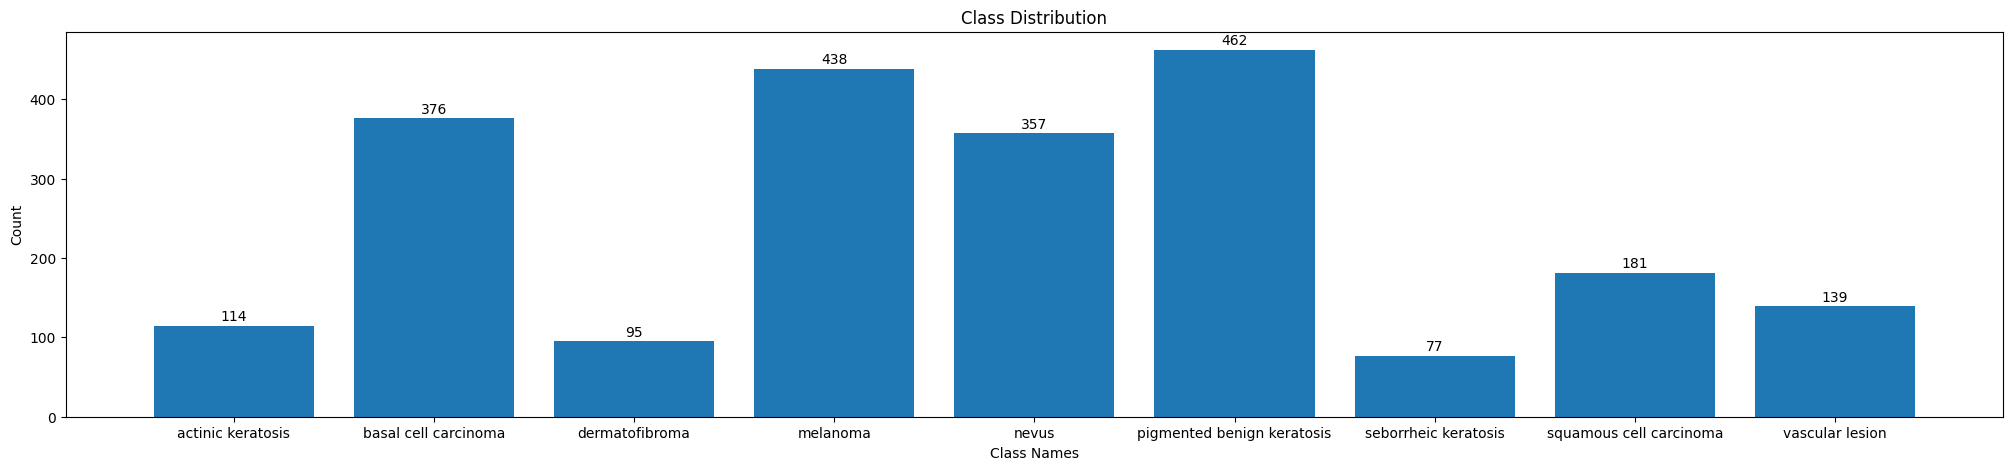

In [231]:
# Plotting the number of images in each Class
count = []
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
plt.figure(figsize=(25,5))
plt.bar(class_names, count)

for i, c in enumerate(count):
    plt.text(i, c + 3, str(c), ha='center', va='bottom')

plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

### Findings:
#### 'seborrheic keratosis' has least samples
#### 'pigmented benign keratosis' has highest number of samples
       


#### Rectifying the class imbalance using 'Augmentor'

In [232]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [233]:
# Running the Augmentation to create more samples
path_to_training_dataset = data_root_directory+'Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x395556300>: 100%|██████████| 500/500 [00:01<00:00, 443.93 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3736A1A30>: 100%|██████████| 500/500 [00:01<00:00, 458.91 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x36703D6A0>: 100%|██████████| 500/500 [00:01<00:00, 461.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x34D5F4110>: 100%|██████████| 500/500 [00:06<00:00, 81.85 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x38BD5ED80>: 100%|██████████| 500/500 [00:05<00:00, 84.27 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3762F9F70>: 100%|██████████| 500/500 [00:01<00:00, 446.21 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x395E6ED80>: 100%|██████████| 500/500 [00:02<00:00, 204.20 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x367009940>: 100%|██████████| 500/500 [00:01<00:00, 446.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/ejanjanam/Projects/Personal/jupyter_notebooks/datasets/MelanomaData/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x38BD3A540>: 100%|██████████| 500/500 [00:01<00:00, 451.96 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [234]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [235]:
from glob import glob
# Getting the path of new data
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# Getting the list of names
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# Creating a dataframe
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [236]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [237]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2], axis=0)
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [238]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating training dataset

In [239]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [240]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model 3 - Using Augmented Images

In [241]:
model3 = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [242]:
model3.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,033 (4.02 MB)

 Trainable params: 1,053,033 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model 3

In [243]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model 3

In [244]:
%%time
epochs = 30
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.1569 - loss: 2.1639 - val_accuracy: 0.2858 - val_loss: 1.8255
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.2837 - loss: 1.8191 - val_accuracy: 0.3712 - val_loss: 1.6388
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.3826 - loss: 1.6114 - val_accuracy: 0.4543 - val_loss: 1.5201
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.4383 - loss: 1.4899 - val_accuracy: 0.4395 - val_loss: 1.4755
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.4461 - loss: 1.4489 - val_accuracy: 0.4699 - val_loss: 1.4017
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4593 - loss: 1.4021 - val_accuracy: 0.4907 - val_loss: 1.3749
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.4745 - loss: 1.3545 - val_accuracy: 0.4885 - val_loss: 1.3246
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.4710 - loss: 1

#### Visualizing the model 3 results

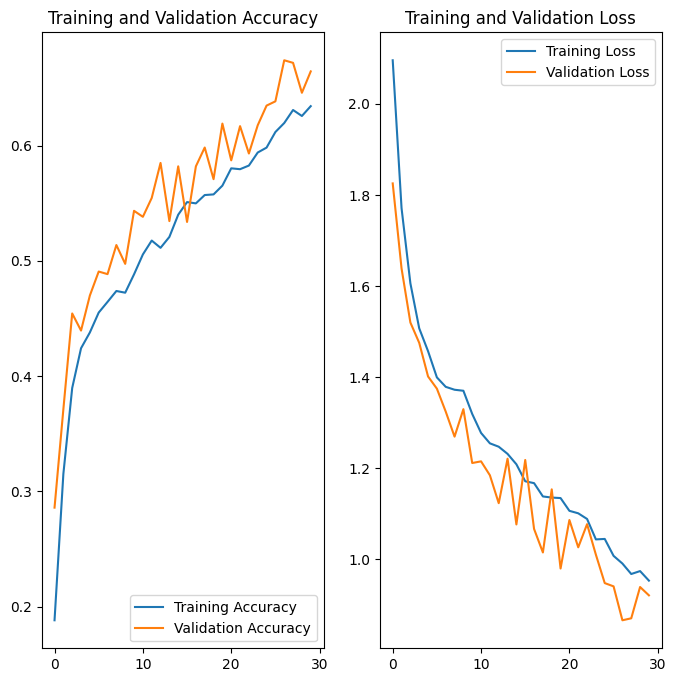

In [245]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of Model 3:

##### For Training -> accuracy: 0.6319 - loss: 0.9514
##### For Validation -> val_accuracy: 0.6644 - val_loss: 0.9212
##### Both are almost same.

##### Overfitting/Underfitting is reduced. Class re-balance does helped.

### Model 4 - Using BatchNormalization

In [251]:
model4 = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [252]:
model4.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,097 (4.02 MB)

 Trainable params: 1,053,065 (4.02 MB)

 Non-trainable params: 32 (128.00 B)

In [253]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [254]:
%%time
epochs = 30
history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.2982 - loss: 1.8438 - val_accuracy: 0.3274 - val_loss: 2.0801
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.4264 - loss: 1.4896 - val_accuracy: 0.2932 - val_loss: 1.9458
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.4712 - loss: 1.3914 - val_accuracy: 0.3890 - val_loss: 1.7059
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.4951 - loss: 1.3347 - val_accuracy: 0.5360 - val_loss: 1.2224
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.5209 - loss: 1.2462 - val_accuracy: 0.4246 - val_loss: 1.6803
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.5399 - loss: 1.2093 - val_accuracy: 0.5724 - val_loss: 1.2284
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.5547 - loss: 1.1624 - val_accuracy: 0.3578 - val_loss: 1.7747
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.5613 - loss: 1

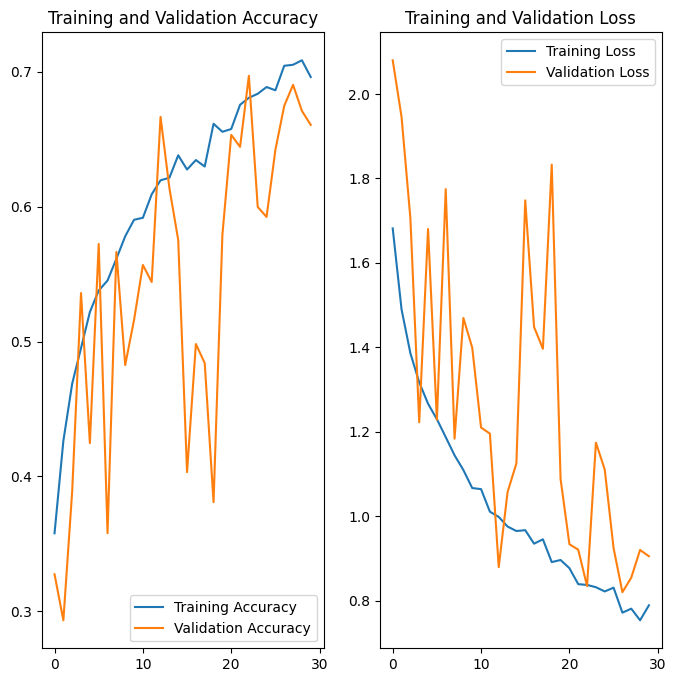

In [255]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings of Model 4:

##### For Training -> accuracy: 0.7070 - loss: 0.7334
##### For Validation -> val_accuracy: 0.4915 - val_loss: 1.6740
##### Validation accuracy got reduced.
##### BatchNormalization made the validation results more unstable


## Model 3 is able to generalize well among all.

In [256]:
# Loading test dataset images
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### Making a prediction using model 3 on test data

In [259]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[-1], target_size=(180, 180, 3))

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model3.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma
